# Setting up kaggle to download dataset

We're gonna be using the anime face dataset from Kaggle. https://www.kaggle.com/datasets/splcher/animefacedataset

This contains 63000 images of anime characters. Visit the website for more information.

In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download splcher/animefacedataset

 97% 381M/395M [00:04<00:00, 111MB/s]
100% 395M/395M [00:04<00:00, 93.6MB/s]


In [6]:
!mkdir ./animefacedataset

In [7]:
!unzip -q animefacedataset.zip -d ./animefacedataset

# Checking out if our dataset is correctly downloaded

In [8]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [9]:
print(os.listdir(DATA_DIR+'/images')[:10])

['13988_2006.jpg', '47837_2014.jpg', '5860_2003.jpg', '14126_2006.jpg', '59706_2018.jpg', '58084_2017.jpg', '279_2000.jpg', '16817_2007.jpg', '8841_2004.jpg', '18323_2007.jpg']


# Creating a PyTorch Dataset and DataLoader

In [10]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [11]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as transforms

In [12]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
# Creating a transform for our images
img_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*stats)  # Normalize with mean and std 0.5 for each channel
])

In [14]:
train_dataset = ImageFolder(root=DATA_DIR,
                            transform=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

In [15]:
images, _ = next(iter(train_dataloader))
images.shape, _.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

In [16]:
_.unique(), _[:10]  # All the labels are 0.

(tensor([0]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

# Creating helper functions to denormalize images and visualize images from a training batch.

In [17]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def denorm(img_tensors):
  return img_tensors * stats[0][1] + stats[0][0]

In [19]:
# Helper function fo show images
def show_images(images, nmax=64):
  images = images.to('cpu') # Move images to cpu because gpu tensors are not compatible with matplotlib.
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0)) # detaching images so that gradients are not affected.

# Helper function to show batch
def show_batch(dataloader, nmax=64):
  images, _ = next(iter(dataloader))
  show_images(images)

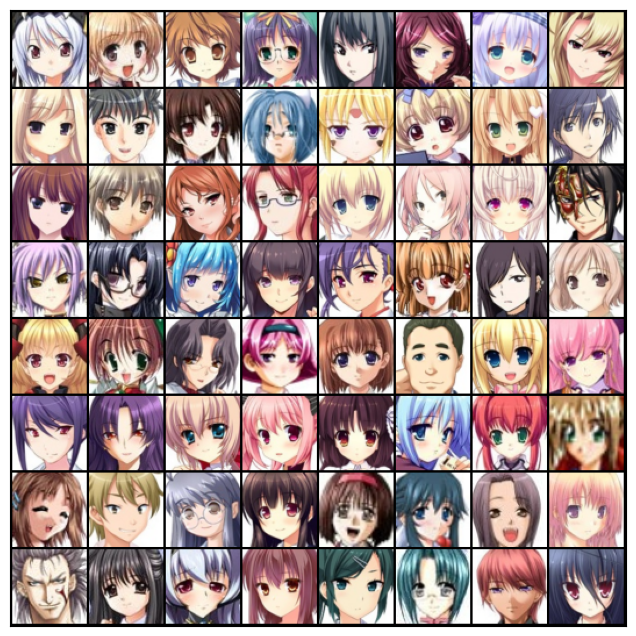

In [20]:
show_batch(train_dataloader)

# Creating the discriminator

We are replicating the DCGAN discriminator given in the paper. The paper has 3 major changes for the discriminator -
- Replace pooling layers with strided convolutions. Stride = 2.
- Use batchnorm
- Use LeakyReLU in discriminator for all layers except the last layer.
The kernel size is 4 for all layers.

The architecture is as follows -
* 3 x 64 x 64 --> 64 x 32 x 32
* 64 x 32 x 32 --> 128 x 16 x 16
* 128 x 16 x 16 --> 256 x 8 x 8
* 256 x 8 x 8 --> 512 x 4 x 4
* 512 x 4 x 4 --> 1 x 1 x 1



In [21]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten()
    )

In [22]:
# Move model to target device
discriminator = discriminator.to(device)

In [23]:
# Check which device our model is on.
next(discriminator.parameters()).device

device(type='cuda', index=0)

# Creating the Generator

The size of the input noise tensor is 128. This is passed to the Conv Net as the input.

The paper proposes 3 main changes to the generator network -
- Replace pooling layers with fractional strided convolutions (transposed convolutions)
- Use batchnorm
- Use ReLU in all layers except output which uses Tanh.

The network architecture is shown in the paper as -
![architecture.png](https://raw.github.com/suryansh-sinha/AnimeFaceGenerator/main/architecture.png)

In [24]:
latent_size = 128

In [25]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [26]:
generator = generator.to(device)

torch.Size([128, 3, 64, 64])


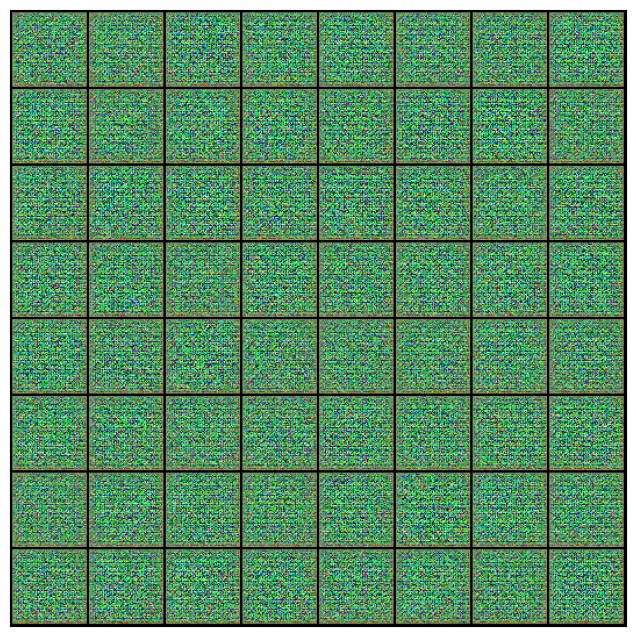

In [27]:
p_z = torch.randn(batch_size, latent_size, 1, 1).to(device) # random latent tensors
fake_images = generator(p_z)
print(fake_images.shape)
show_images(fake_images)

# Discriminator Training

In [28]:
def train_discriminator(real_images, loss_fn, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_images = real_images.to(device)
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = loss_fn(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()  # Takes the mean of predictions made on real data. The closer to 1, the better.

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = loss_fn(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()  # Takes the mean of predictions made on fake data. The closer to 0, the better.

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [29]:
def train_generator(loss_fn, opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = loss_fn(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [30]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
from torchvision.utils import save_image

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [32]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


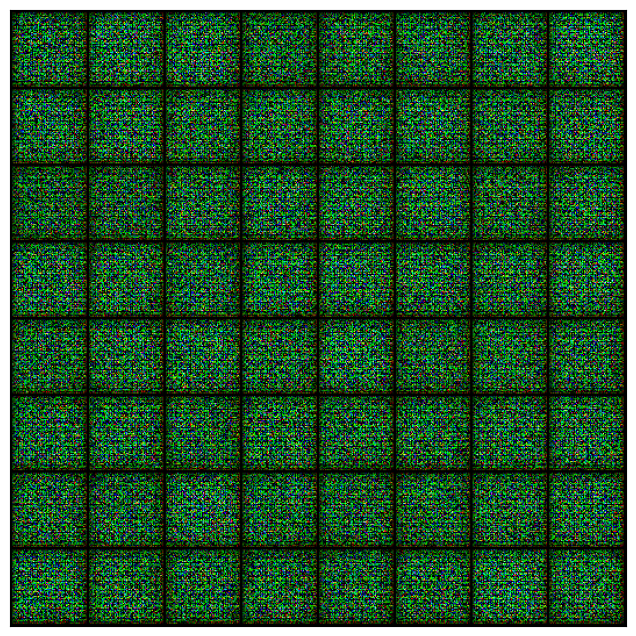

In [33]:
save_samples(0, fixed_latent)

In [34]:
from tqdm.auto import tqdm
import torch.nn

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Create loss function
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dataloader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, loss_fn, opt_d)
            # Train generator
            loss_g = train_generator(loss_fn, opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}] | Generator Loss: {:.4f} | Discriminator Loss: {:.4f} | Real Score: {:.4f} | Fake Score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [36]:
lr = 0.0002
epochs = 25

losses_g, losses_d, real_scores, fake_scores = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25] | Generator Loss: 7.7532 | Discriminator Loss: 1.0928 | Real Score: 4.4020 | Fake Score: 0.4774
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25] | Generator Loss: 3.8709 | Discriminator Loss: 0.1073 | Real Score: 3.3033 | Fake Score: -5.0531
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25] | Generator Loss: 7.9499 | Discriminator Loss: 0.4046 | Real Score: 4.9446 | Fake Score: -0.9958
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25] | Generator Loss: 3.6903 | Discriminator Loss: 0.0723 | Real Score: 5.3887 | Fake Score: -3.7223
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25] | Generator Loss: 10.6701 | Discriminator Loss: 0.4887 | Real Score: 4.4638 | Fake Score: -0.8863
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25] | Generator Loss: 9.8393 | Discriminator Loss: 0.3159 | Real Score: 3.8209 | Fake Score: -1.6995
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25] | Generator Loss: 14.3951 | Discriminator Loss: 0.0291 | Real Score: 5.6125 | Fake Score: -10.1215
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25] | Generator Loss: 4.5454 | Discriminator Loss: 0.0844 | Real Score: 4.4351 | Fake Score: -4.3452
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25] | Generator Loss: 19.9562 | Discriminator Loss: 1.2319 | Real Score: 13.9779 | Fake Score: -3.0421
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25] | Generator Loss: 6.6793 | Discriminator Loss: 0.0653 | Real Score: 6.2331 | Fake Score: -3.3240
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25] | Generator Loss: 6.6327 | Discriminator Loss: 0.0116 | Real Score: 7.1680 | Fake Score: -6.4715
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25] | Generator Loss: 4.5954 | Discriminator Loss: 0.0945 | Real Score: 4.7367 | Fake Score: -4.8554
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25] | Generator Loss: 5.9633 | Discriminator Loss: 0.0349 | Real Score: 6.8363 | Fake Score: -4.5087
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25] | Generator Loss: 6.5596 | Discriminator Loss: 0.0723 | Real Score: 6.4000 | Fake Score: -3.5013
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25] | Generator Loss: 9.9814 | Discriminator Loss: 0.1091 | Real Score: 5.6495 | Fake Score: -6.3106
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25] | Generator Loss: 18.8971 | Discriminator Loss: 0.0504 | Real Score: 5.7255 | Fake Score: -15.7020
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25] | Generator Loss: 6.5482 | Discriminator Loss: 0.0804 | Real Score: 6.0813 | Fake Score: -4.7288
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25] | Generator Loss: 5.9267 | Discriminator Loss: 0.1718 | Real Score: 5.3589 | Fake Score: -3.3551
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25] | Generator Loss: 6.4279 | Discriminator Loss: 0.0588 | Real Score: 6.1314 | Fake Score: -4.6374
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25] | Generator Loss: 8.8743 | Discriminator Loss: 0.1032 | Real Score: 5.7027 | Fake Score: -3.2071
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25] | Generator Loss: 7.6678 | Discriminator Loss: 0.0418 | Real Score: 8.3780 | Fake Score: -3.6004
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25] | Generator Loss: 8.3415 | Discriminator Loss: 0.0169 | Real Score: 6.4176 | Fake Score: -6.3370
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25] | Generator Loss: 7.8745 | Discriminator Loss: 0.0353 | Real Score: 6.6402 | Fake Score: -6.4421
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25] | Generator Loss: 25.5018 | Discriminator Loss: 0.0082 | Real Score: 8.8398 | Fake Score: -19.2546
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25] | Generator Loss: 10.2114 | Discriminator Loss: 0.0357 | Real Score: 6.4544 | Fake Score: -7.9272
Saving generated-images-0025.png


In [37]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

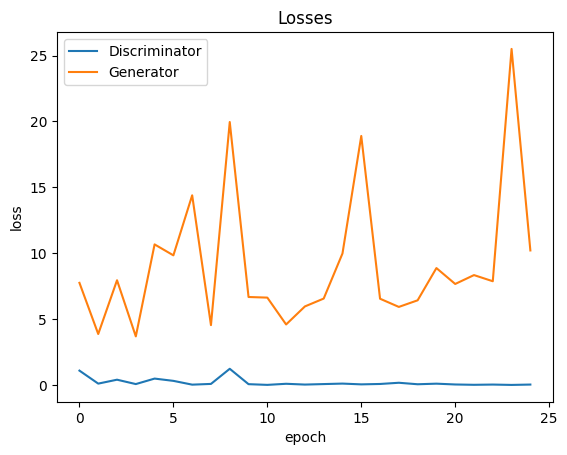

In [38]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

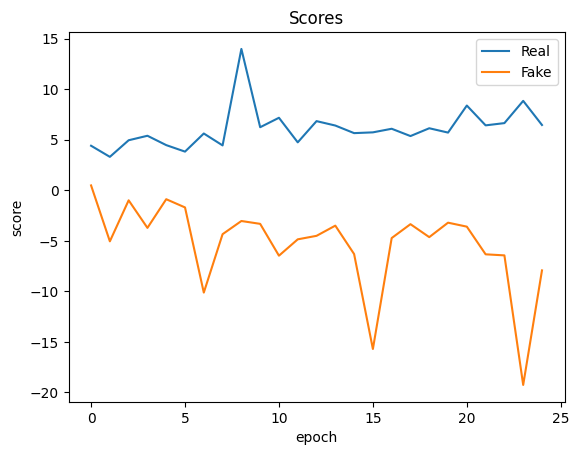

In [39]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [40]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()